In [12]:
# %matplotlib qt
# PACKAGES
import matplotlib
import scipy as sp
import scipy.constants as const
import scipy.integrate as integrate
import scipy.linalg as ln
import cmath
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse as sparse

plt.style.use('seaborn-paper')

# CONSANTS

# ALL CONSTANTS ARE IN HARTREE UNITS FOR EASE AND ACCURACY OF CALCULATION
hbar = 1
echarge = 1
mass = 1

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 22})


### 1D potential and transmission generating class:

In [2]:
class Landscape:   
    """ 'Landscape' calculates everything related to transmission probabilities and shows graphical representations of 
    potentials, wavenumbers and the wavefunction """
    def __init__(self, precision, len_pot, barrier, energy):
        # setting values for calling in later functions
        self.precision = precision
        self.len_pot = len_pot
        self.energy = energy
        self.barrier = barrier
        self.no_steps = self.precision*self.len_pot
        # self.x_vals is essentially len_pot but incremented by no_steps
        self.x_vals = np.linspace(0, len_pot, self.no_steps)
        self.V = np.zeros(self.no_steps)
        self.k = np.zeros(self.no_steps, dtype = np.complex_)
        
        for i in range(len(self.barrier)):
            # for each region defined in 'barrier', finds the length of that region in terms of the number of steps it is
            len_reg = round(self.barrier[i][1][1] - self.barrier[i][1][0],8)
            # creates matrix starting from 0 and spanning length of region so that potential is not 'shifted up' based on its
            # position 
            shape_mat = np.arange(0, len_reg*self.precision)
            # creates shape of potential
            shape_i = self.barrier[i][0](shape_mat)
            # now slots this potential back into the position where it should be in the overall potential landscape
            self.V[round(self.barrier[i][1][0]*self.precision): 
              round(self.barrier[i][1][1]*self.precision)] = shape_i
        
        for j in range(self.no_steps):
            E_fail = self.energy
            if E_fail == self.V[j]:    ## stops a divide by zero error when E == V by adding a neglibible amount to E
                E_fail += 1e-14
                self.k[j] = cmath.sqrt(2*echarge*mass*(E_fail-self.V[j]))/hbar
            else:
                self.k[j] = cmath.sqrt(2*echarge*mass*(self.energy-self.V[j]))/hbar
                               
    def potential(self, graph=True):
        """ 'potential' graphs the landscape and returns the array of V values when graph == True, or just returns the array
        when graph == False """
        # potential landscape
        if graph == True:
            fig,ax1=plt.subplots()
            ax1.set_title('Potential Landscape')
            ax1.set_xlabel('x (a$_0$)')
            ax1.set_ylabel('V(x) (E$_h$)')
            ax1.grid('on')
            ax1.fill_between(self.x_vals,self.V,alpha = 0.2)
            ax1.plot(self.x_vals, self.V, label='Potential energy (E$_h$)')
            ax1.legend() 
            return self.V
        else:
            return self.V
           
    def wavenumber(self, graph=True):
        """ 'wavenumber' graphs a schematic representation of the wavenumber and returns the array of k values at each point 
        if graph == True, or just the array when graph == False """
        if graph == True:
            fig,ax2=plt.subplots()          ## plots wavenumber on axes
            ax2.set_title('Wavenumber')
            ax2.set_xlabel('x (a$_0$)')
            ax2.set_ylabel('k (schematic)')
            ax2.grid('on')
            ax2.plot(self.x_vals, self.k.real, label='Real component of k')
            ax2.plot(self.x_vals, self.k.imag, label='Imaginary component of k')
            ax2.legend() 
            return self.k
        else:
            return self.k
    
    def propagation_matrix(self):
        """ 'propagation_matrix' carries out the propagation matrix method (PMM) calculations for a given energy, returning
        the probability of transmission through the potential barrier defined for a given energy. This is based on the
        documentation given by A. F. J Levi on pg. 176 of Chapter 4, Applied Quantum Mechanics. """
        N = self.no_steps
        k = self.k
        N_matrix = np.arange(N)
        
        P = [[1.+0j,0.+0j],[0.+0j,1.+0j]]
    
        for j in range(N-1):            
            a = (0.5*(1+(k[j+1]/k[j])))*cmath.exp(-1j*k[j]*(N_matrix[j+1]-N_matrix[j])*(1/self.precision))
            b = (0.5*(1-(k[j+1]/k[j])))*cmath.exp(-1j*k[j]*(N_matrix[j+1]-N_matrix[j])*(1/self.precision))
            c = (0.5*(1-(k[j+1]/k[j])))*cmath.exp(1j*k[j]*(N_matrix[j+1]-N_matrix[j])*(1/self.precision))
            d = (0.5*(1+(k[j+1]/k[j])))*cmath.exp(1j*k[j]*(N_matrix[j+1]-N_matrix[j])*(1/self.precision))
        
            p_j = [[a,b],[c,d]]
            
            P = np.matmul(P, p_j)
        
        return (((1/(P[0][0]*np.conj(P[0][0])))**0.5).real)
    
    def wavefunction(self):
        """ 'wavefunction' graphs the wavefunction of a particle incident on the potential barrier (with plans to eventually
        expand this to calulate probability on boths sides and compare)"""
        N = self.no_steps
        V = self.V
        x = self.x_vals

        diag = np.zeros(N)
        offdiag = np.zeros(N-1)

        # uses a finite difference method to represent the Hamiltonian as a tri-diagonal matrix
        for i in range(N):
            diag[i] = 1 + V[i]
        for i in range(N-1):
            offdiag[i] = -0.5
        
        # uses scipy.sparse.linalg library's matrix solving functionalities to find eigenenergies and thus eigenfunctions
        # for the quantum Hamiltonian operator
        a, b = ln.eigh_tridiagonal(diag,offdiag)
     
        fig, ax1 = plt.subplots()
        fig, ax2 = plt.subplots()
        
        ax1.fill_between(x,1*V*self.precision,alpha = 0.2)
        ax1.plot(x,1*V*self.precision)
        
        l = 7
        eiglist = []
        for i in range(0,l):
            # ensures on incident from left are plotted
            if np.argmax(b[0:,i]) < N/2 and not np.sum(V) == 0:
                norm = (b[0:,i].dot(b[0:,i]))**0.5
                b[0:,i] /= norm 
                ax1.plot(x,(b[0:,i] + a[i]*self.precision/10),label = 'E$_{}$'.format(int(i)))
                eiglist.append(a[i])
                
            else:
                norm = (b[0:,i].dot(b[0:,i]))**0.5
                b[0:,i] /= norm 
                ax1.plot(x,(b[0:,i] + a[i]*self.precision/10),label = 'E$_{}$'.format(int(i)))
                eiglist.append(a[i])
        
        ax1.set_xlabel('x (a$_0$)')
        ax1.set_ylabel('E (schematic)')
        ax1.set_title('Visualisation of stationary states in infinte square well')         
        ax1.grid('on') 
        ax1.legend(bbox_to_anchor=(1.05, 0.85), loc='upper right')
        
        no_eig = np.arange(0,l,dtype = 'int_')
        ax2.set_xlabel('n')
        ax2.set_ylabel('n$^t$$^h$ eigenenergy (E$_h$)')
        ax2.set_title('Eigenenergy for n$^t$$^h$ eigenstate')
        ax2.set_xticks(no_eig)
        ax2.grid('on')
        ax2.plot(np.arange(len(eiglist)),eiglist,'d',label = 'Eigenenergies')
        ax2.legend(bbox_to_anchor=(1.275, 1), loc='upper right')

### Plot generating class:

In [3]:
# energy list 
class Grapher:
    """ 'Grapher' takes the propagation_matrix values from the 'Landscape' class above and plots the probability of transmission
    for a range of different energies """
    def __init__(self,start,end,interval,landscape):
        self.elist = np.linspace(start,end,interval)
        self.landscape = landscape
        self.N = len(self.elist)
        
    def grapher(self):
        tarr = np.zeros(self.N)
        for j in range(self.N):
            tarr[j] = self.landscape(self.elist[j])
                  
        fig,ax3=plt.subplots()
        ax3.set_title('Trans(E) vs. incident particle energy in E$_h$')
        ax3.set_xlim(-0.05,1.05)
        ax3.set_xlabel('Trans(E)')
        ax3.set_ylabel('E (E$_h$)')
        ax3.grid('on')
        ax3.plot(tarr,self.elist,label='Trans(E)',alpha = 0.85)
        #ax3.plot(tanallist,self.elist,'rd',label='Trans(E) (Analytical)',alpha = 0.4)
        ax3.legend()

        fig,ax4=plt.subplots()
        ax4.set_title('-ln(Trans(E)) vs. incident particle energy in E$_h$')
        ax4.set_xlabel('-ln(Trans(E))')
        ax4.set_ylabel('E (E$_h$)')
        ax4.grid('on')
        ax4.set_xlim(-0.25,10)
        ax4.plot(-np.log(tarr),self.elist,label='-ln(Trans(E))',alpha = 0.85)
        #ax4.plot(-np.log(tanallist),self.elist,'rd',label='-ln(Trans(E)) (Analytical)',alpha = 0.4)
        ax4.legend()            

#### Plots

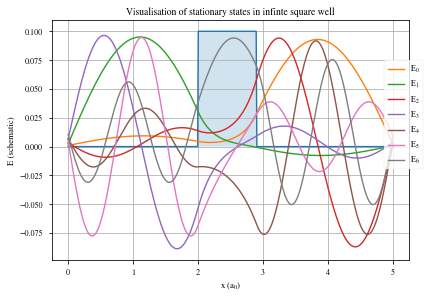

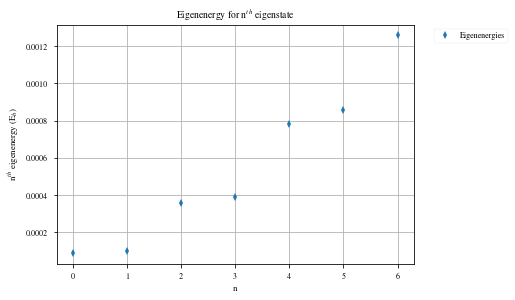

In [4]:
# Landscapes should be of the form:
# Landscape(precision, len_pot, barrier, energy) 

# Landscape1 = lambda E: Landscape(100,100,[(lambda x: 1+0*x,[1,3]),(lambda x: 1+0*x,[97,99])],E).propagation_matrix()
# Landscape(100,100,[(lambda x: 0.5+0*x,[1,3]),(lambda x: 0.5+0*x,[97,99])],1).potential()
# Landscape(100,9,[(lambda x: 1+0*x,[2,7])],0.8).potential()
#Landscape(100,1,[(lambda x: 0.25*(x/100 -0.5)**2,[0,1])],0.8).wavefunction()
Landscape(100,5,[(lambda x: 0.001,[2,2.9])],0.8).wavefunction()
# Landscape3 = lambda E: Landscape(100,12,[(lambda x: ((x/100 - 5)**2)/25,[1,11])],E).propagation_matrix()
# Landscape(100,12,[(lambda x: ((x/100 - 5)**2)/25,[1,11])],1).potential()


# Grapher is of the form:
# Grapher(start energy, end energy, no steps, Landscape).

#Grapher(0,1.5,100,Landscape1).grapher()
#Grapher(0,2.5,100,Landscape2).grapher()
#Grapher(0,1.5,1501,Landscape3).grapher()

In [5]:
class Surface:    
    """ 'Surface' creates a visualisation of a given surface from its equation and slices this surface based on a linear 
    equation which is also given. The values of potential along this 'slicing equation' are then plotted and returned 
    separately, which turns a 2D path into a 1D transmission problem (eventually one will be able to pass these into 
    Landscape.propagation_matrix() above so one can graph these probabilities """
    def __init__(self,bot,top,inc,surf_eqn,slice_eqn):
        self.top = top
        self.bot = bot
        self.inc = inc
        x_len = top - bot
        y_len = top - bot
        self.z = surf_eqn
        self.slice = slice_eqn
        
        x = np.linspace(bot,top,int(1/inc))
        y = np.linspace(bot,top,int(1/inc))
        
        y_temp = self.slice(x)
        dx = np.max(x)-np.min(x)
        dy = np.max(y_temp)-np.min(y_temp)
        l = (dx**2 + dy**2)**0.5

        self.X,self.Y = np.meshgrid(x,y)
        
        # detects whether the slice equation is of the form y = f(x) or x = f(y). For this reason, the surface equation must
        # be in a and b.

        y = self.slice(x)
        j_list = []

        for j in range(len(x)):     ## ensures that x and y are both in bounds
            if y[j] < top and y[j] > bot and x[j] < top and x[j] > bot:
                j_list.append(j)        

        self.x1 = x[j_list]
        self.y1 = y[j_list]
        
        bot_x = np.min(self.x1)
        bot_y = np.min(self.y1)
        x_ = np.linspace(bot_x,bot_x+dx,int(l/inc))
        y_ = np.linspace(bot_y,bot_y+dy,int(l/inc))        

        # adds a zone of zeros above and below the x and y range to ensure that the PMM algorithm works
        x_ = np.concatenate((np.arange(bot_x-1,bot_x,inc),x_,np.arange(bot_x+dx,bot_x+dx+1,inc)),axis=0) 
        y_ = np.concatenate((np.arange(bot_y-1,bot_y,inc),y_,np.arange(bot_y+dy,bot_y+dy+1,inc)),axis=0) 
        z_ = np.zeros(len(x_))

        self.n = np.arange(0,len(x_))

        for j in range(len(x_)):
            if x_[j] >= bot_x and x_[j] <= bot_x + dx -inc:
                z_[j] = self.z(x_[j],y_[j])

        self.V = z_

    def graph(self):
        surfslice_fig = plt.figure(figsize=(10,10)) 
        ax_surfslice = surfslice_fig.gca(projection='3d')
        ax_surfslice.set_title('Potential Surface')
        slicefig,ax_slice = plt.subplots(figsize=(7,7))

        ax_surfslice.plot(self.x1,self.y1,self.z(self.x1,self.y1),alpha=0.75,linewidth=3,color='blue',label='Potential slice')
            ## visualise the slice
        surfslice1 = ax_surfslice.plot_surface(self.X,self.Y,self.z(self.X,self.Y),alpha=0.33,color='red',label='Potential energy (E$_h$)')
        surfslice1._facecolors2d=surfslice1._facecolors3d
        surfslice1._edgecolors2d=surfslice1._edgecolors3d
        ax_surfslice.set_xlabel('x (a$_0$)')
        ax_surfslice.set_ylabel('y (a$_0$)')
        ax_surfslice.set_zlabel('V(x,y) (E$_h$)')
        ax_surfslice.legend()
        #ax_surfslice.view_init(90,0)

        ax_slice.set_title('Potential slice given by line equation')
        ax_slice.set_xlabel('Position in path (a$_0$)')
        ax_slice.set_ylabel('V(x,y) (E$_h$)')
        ax_slice.grid('on')
        N = len(self.n)
        precision = 1/self.inc
        N_matrix = np.linspace(0,N/precision,N)
        ax_slice.fill_between(N_matrix,self.V,alpha = 0.2)
        ax_slice.plot(N_matrix,self.V,label='Potential')
        ax_slice.legend() 
    
    def propagation_matrix(self,E):
        N = len(self.n)
        precision = 1/self.inc
        N_matrix = np.linspace(0,N/precision,N)
        V = self.V
        
        # k VALUES
        k = np.zeros(N,dtype = np.complex_)
        for j in range(N):
            E_fail = E
            if E_fail == V[j]:
                E_fail += 1e-14
                k[j] = cmath.sqrt(2*echarge*mass*(E_fail-V[j]))/hbar
            else:
                k[j] = cmath.sqrt(2*echarge*mass*(E-V[j]))/hbar

        # P calculator
        P= [[1.+0j,0.+0j],[0.+0j,1.+0j]]

        for j in range(N-1):            
            a = (0.5*(1+(k[j+1]/k[j])))*cmath.exp(-1j*k[j]*(N_matrix[j+1]-N_matrix[j]))
            b = (0.5*(1-(k[j+1]/k[j])))*cmath.exp(-1j*k[j]*(N_matrix[j+1]-N_matrix[j]))
            c = (0.5*(1-(k[j+1]/k[j])))*cmath.exp(1j*k[j]*(N_matrix[j+1]-N_matrix[j]))
            d = (0.5*(1+(k[j+1]/k[j])))*cmath.exp(1j*k[j]*(N_matrix[j+1]-N_matrix[j]))

            p_j = [[a,b],[c,d]]

            P = np.matmul(P,p_j)

        return (((1/(P[0][0]*np.conj(P[0][0])))**0.5).real)



#### Plots

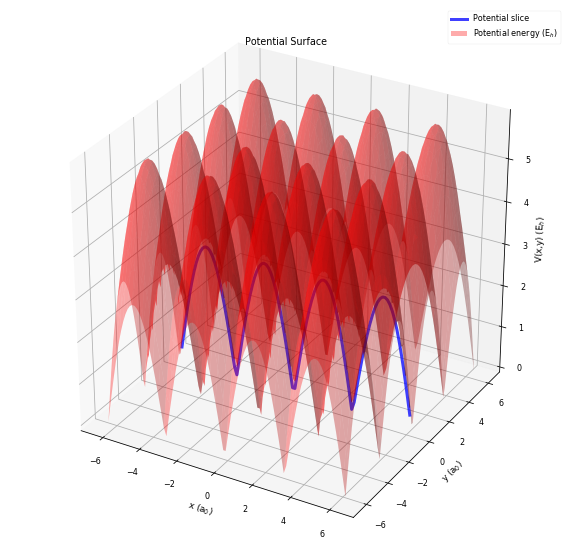

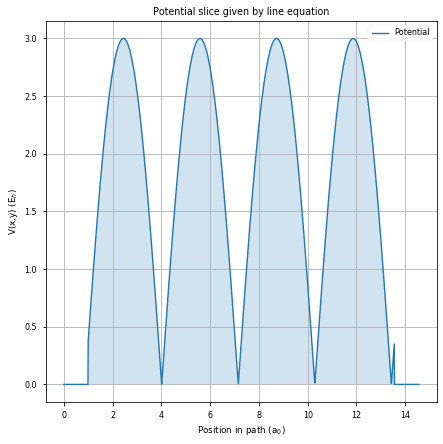

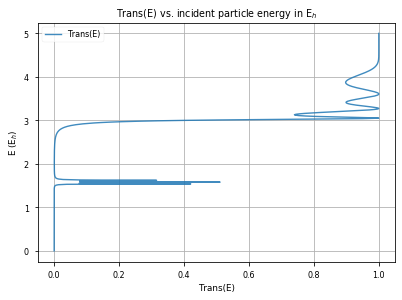

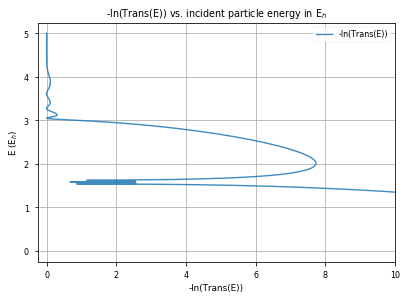

In [6]:
# Surf1 = lambda E: Surface(-1.5,1.5,0.01,lambda a,b: np.sin(a**2 + b**2),lambda x: 0.1 + 0*x).propagation_matrix(E)
# Surface(-1.5,1.5,0.01,lambda a,b: np.sin(a**2 + b**2),lambda x: 0.1 + 0*x).graph()
Surface(-2*np.pi,2*np.pi,0.01,lambda a,b: 3*abs(np.sin(a)) + 3*abs(np.sin(b)),lambda x: 0 + 0*x).graph()
Surf2 = lambda E: Surface(-2*np.pi,2*np.pi,0.01,lambda a,b: 3*abs(np.sin(a)) + 3*abs(np.sin(b)),lambda x: 0 + 0*x).propagation_matrix(E)

Grapher(0,5,501,Surf2).grapher()

### Anderson Localisation

#### TISE

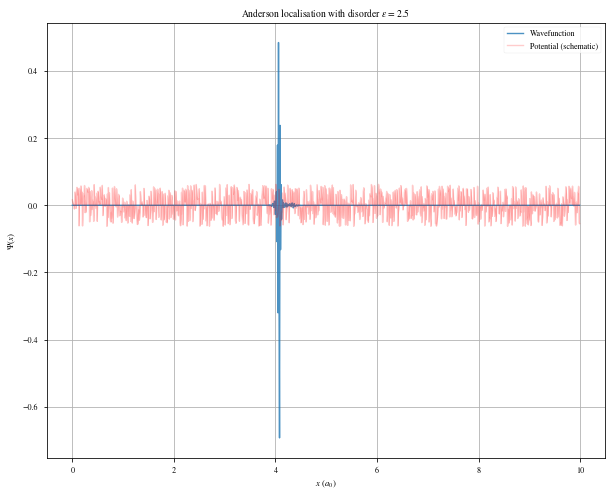

In [14]:
L = 10
precision = 100
N = L * precision
W = 2.5
E = 1
disorder = np.random.uniform(-W/2,W/2,size=(N))

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 22})

V = 0.5
# for i in range(N):
#     Vlist[i] = V#+disorder[i]
    

diag = np.zeros(N)
offdiag = np.zeros(N)

for i in range(N):
    diag[i] = disorder[i]  + V#list[i]
for i in range(N):
    offdiag[i] = - 0.5
    
H = np.zeros(shape=(N,N))    
for j in range(N):
# the following line to ensure periodic boundary conditions    
        per = (j+1) % N
        H[j,j] = diag[j]
        H[j,per] = offdiag[j]
        H[per,j] = offdiag[j]

(energy_levels,eigenstates)=ln.eigh(H)

i=np.argmin(abs(energy_levels - E))
jarr = np.zeros(N)
earr = np.zeros(N)
for j in range(N):
    jarr[j] = j
    earr[j] = eigenstates[j,i]
    
    
fig, alax1 = plt.subplots(figsize=(10,8))

alax1.set_xlabel('$x$ $(a_0)$')
alax1.set_ylabel('$\Psi(x)$')
alax1.plot(jarr/precision,earr,label = 'Wavefunction',alpha = 0.8)
alax1.plot(jarr/precision,V*disorder/10,alpha = 0.2,color = 'r',label = 'Potential (schematic)')
alax1.set_title('Anderson localisation with disorder $\epsilon$ = {}'.format(W) )
alax1.grid('on')
plt.fill_between(jarr/precision,V*disorder/10,alpha = 0.2,color = 'r')
alax1.legend()
fig.savefig(os.path.join(os.getcwd(), *['localisation_figures','disorder_{}.pdf'.format(W)]), format = 'pdf')
plt.show()